In [140]:
import os
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import numpy as np
import soundfile as sf

# from soundbay.utils.metadata_processing import create_wav_info_df, convert_month_annotation_to_file_anotation
from soundbay.utils.metadata_processing import get_wav_info_df, add_month_acc_duration, load_corrected_annotation_df

BASE_PATH = Path(os.getcwd())
DATASET_PATH = BASE_PATH / "datasets/fannie_project"
print(DATASET_PATH)

/mnt/d/DeepVoice/soundbay/datasets/fannie_project


In [141]:
wav_df = get_wav_info_df(DATASET_PATH, file_format="fannie", order_by="date_time")
wav_df = add_month_acc_duration(wav_df)
wav_df.head()

Processing wav files: 100%|██████████| 9276/9276 [00:29<00:00, 316.41it/s]


wav_file    duration  sample_rate  \
0  /mnt/d/DeepVoice/soundbay/datasets/fannie_proj...  840.025500        96000   
1  /mnt/d/DeepVoice/soundbay/datasets/fannie_proj...  840.004667        96000   
2  /mnt/d/DeepVoice/soundbay/datasets/fannie_proj...  840.008000         1000   
3  /mnt/d/DeepVoice/soundbay/datasets/fannie_proj...  840.022000         1000   
4  /mnt/d/DeepVoice/soundbay/datasets/fannie_proj...  840.023000         1000   

  rec_id           date_time month_year  accumulated_duration  
0   5756 2021-04-15 18:29:58     4-2021              0.000000  
1   5756 2021-04-15 19:29:58     4-2021            840.025500  
2   5756 2021-04-15 20:29:58     4-2021           1680.030167  
3   5756 2021-04-15 21:29:58     4-2021           2520.038167  
4   5756 2021-04-15 22:29:58     4-2021           3360.060167

In [142]:
ant_blue_annotation = load_corrected_annotation_df(DATASET_PATH / "ANT_BLUE", wav_df)
mad_blue_annotation = load_corrected_annotation_df(DATASET_PATH / "MAD_BLUE", wav_df)

ant_blue_annotation.head(3)

Selection           View  Channel  begin_time    end_time  High Freq (Hz)  \
0          1  Spectrogram 1        1  831.942378  838.218523          26.831   
1          2  Spectrogram 1        1   47.070881   53.849117          26.551   
2          3  Spectrogram 1        1  108.075012  115.982955          26.551   

   Low Freq (Hz)  Peak Freq (Hz)  Delta Time (s)  Dur 90% (s)  \
0         24.036          25.195          6.2761       5.3805   
1         23.757          24.609          6.7782       6.0674   
2         23.477          25.195          7.9079       5.9529   

   SNR NIST Quick (dB)               wav_file           date_time  duration  \
0                 6.96  5756.210501212958.wav 2021-05-01 21:29:58   840.016   
1                 9.95  5756.210502002958.wav 2021-05-02 00:29:58   840.004   
2                11.75  5756.210502002958.wav 2021-05-02 00:29:58   840.004   

   accumulated_duration  
0             17640.022  
1             20160.030  
2             20160.030

In [143]:
def check_annotation_file(annotation_df):
    cnt_bad_start_times = 0
    cnt_bad_end_times = 0
    months_year = set()
    for _, row in tqdm(annotation_df.iterrows(), total=annotation_df.shape[0], desc="Checking annotation times"):
        start_time = row['begin_time']
        end_time = row['end_time']
        
        file_duration = row['duration']
        if start_time < 0 or start_time >= file_duration:
            months_year.add(f"{row['date_time'].month}-{row['date_time'].year}")
            cnt_bad_start_times += 1
        if end_time < 0 or end_time > file_duration:
            months_year.add(f"{row['date_time'].month}-{row['date_time'].year}")
            cnt_bad_end_times += 1
    print(f"Number of invalid start times: {cnt_bad_start_times}")
    print(f"Number of invalid end times: {cnt_bad_end_times}")
    print(f"Months with invalid annotations: {months_year}")

In [144]:
check_annotation_file(annotation_df=ant_blue_annotation)

Checking annotation times: 100%|██████████| 5441/5441 [00:00<00:00, 62702.86it/s]

Number of invalid start times: 157
Number of invalid end times: 161
Months with invalid annotations: {'3-2022'}


In [145]:
check_annotation_file(mad_blue_annotation)

Checking annotation times: 100%|██████████| 9607/9607 [00:00<00:00, 57235.21it/s]

Number of invalid start times: 1694
Number of invalid end times: 1737
Months with invalid annotations: {'3-2022'}


In [146]:
# mad_stats = mad_blue_annotation.groupby('wav_file').agg({
#     'begin_time': ['min', 'max'],
#     'end_time': ['min', 'max']
# })
# mad_stats['date_time'] = mad_stats.index.to_series().apply(lambda x: get_date_time_fannie_format(x))

# mad_stats.columns = ['Begin Time (s) min', 'Begin Time (s) max', 'End Time (s) min', 'End Time (s) max', 'date_time']

# mad_stats = mad_stats.merge(
#     file_df[['date_time', 'duration', 'accumulated_duration']],
#     left_on='date_time',
#     right_on='date_time',
#     how='left'
# )

# mad_stats['Begin Time (s) min'] = mad_stats['Begin Time (s) min'] - mad_stats['accumulated_duration']
# mad_stats['Begin Time (s) max'] = mad_stats['Begin Time (s) max'] - mad_stats['accumulated_duration']
# mad_stats['End Time (s) min'] = mad_stats['End Time (s) min'] - mad_stats['accumulated_duration']
# mad_stats['End Time (s) max'] = mad_stats['End Time (s) max'] - mad_stats['accumulated_duration']
# mad_stats

In [147]:
# there is a problem only in march 2022, so we can filter it out
ant_blue_annotation['month_year'] = ant_blue_annotation.apply(lambda x: f"{x['date_time'].month}-{x['date_time'].year}", axis=1)
ant_blue_annotation = ant_blue_annotation[ant_blue_annotation['month_year'] != "3-2022"]
mad_blue_annotation['month_year'] = mad_blue_annotation.apply(lambda x: f"{x['date_time'].month}-{x['date_time'].year}", axis=1)
mad_blue_annotation = mad_blue_annotation[mad_blue_annotation['month_year'] != "3-2022"]

del ant_blue_annotation['month_year']
del mad_blue_annotation['month_year']

ant_blue_annotation.head(3)

Selection           View  Channel  begin_time    end_time  High Freq (Hz)  \
0          1  Spectrogram 1        1  831.942378  838.218523          26.831   
1          2  Spectrogram 1        1   47.070881   53.849117          26.551   
2          3  Spectrogram 1        1  108.075012  115.982955          26.551   

   Low Freq (Hz)  Peak Freq (Hz)  Delta Time (s)  Dur 90% (s)  \
0         24.036          25.195          6.2761       5.3805   
1         23.757          24.609          6.7782       6.0674   
2         23.477          25.195          7.9079       5.9529   

   SNR NIST Quick (dB)               wav_file           date_time  duration  \
0                 6.96  5756.210501212958.wav 2021-05-01 21:29:58   840.016   
1                 9.95  5756.210502002958.wav 2021-05-02 00:29:58   840.004   
2                11.75  5756.210502002958.wav 2021-05-02 00:29:58   840.004   

   accumulated_duration  
0             17640.022  
1             20160.030  
2             20160.030

In [148]:
# check_annotation_file(annotation_df=ant_blue_annotation)
# check_annotation_file(annotation_df=mad_blue_annotation)

In [149]:
num_ant_blue_calls = ant_blue_annotation.shape[0]
num_mad_blue_calls = mad_blue_annotation.shape[0]
print(f"ANT_BLUE calls: {num_ant_blue_calls}, MAD_BLUE calls: {num_mad_blue_calls}")

ANT_BLUE calls: 5272, MAD_BLUE calls: 7188


In [150]:
# Calculate mean and std for 'Dur 90% (s)' in each annotation dataframe
ant_mean = ant_blue_annotation['Delta Time (s)'].mean()
ant_std = ant_blue_annotation['Delta Time (s)'].std()

mad_mean = mad_blue_annotation['Delta Time (s)'].mean()
mad_std = mad_blue_annotation['Delta Time (s)'].std()

print(f"ANT_BLUE: mean={ant_mean:.2f}, std={ant_std:.2f}")
print(f"MAD_BLUE: mean={mad_mean:.2f}, std={mad_std:.2f}")

ANT_BLUE: mean=6.37, std=1.38
MAD_BLUE: mean=14.43, std=2.25


In [151]:
# Filter wav_df for files recorded in November (month == 11)
november_wavs = wav_df[wav_df['date_time'].dt.month == 11]

def generate_november_sampled_df(annotation_df, target_mean, target_std, november_wavs, random_state):
    n_samples = annotation_df.shape[0] // 2
    columns = annotation_df.columns

    # Randomly sample wav files for November
    sampled_wavs = november_wavs.sample(n=n_samples, replace=True, random_state=random_state).reset_index(drop=True)

    # Generate random durations with the same mean and std as annotation_df
    np.random.seed(random_state)
    delta_times = np.random.normal(loc=target_mean, scale=target_std, size=n_samples)
    delta_times = np.clip(delta_times, 0.1, None)

    # Generate random begin times within each wav file's duration
    begin_times = []
    end_times = []
    for i, row in sampled_wavs.iterrows():
        max_start = max(row['duration'] - delta_times[i], 0.1)
        begin = np.random.uniform(0, max_start)
        end = begin + delta_times[i]
        begin_times.append(begin)
        end_times.append(end)

    # Build the DataFrame
    sampled_df = pd.DataFrame({
        'wav_file': sampled_wavs['wav_file'],
        'begin_time': begin_times,
        'end_time': end_times
    })

    return sampled_df[columns]

ant_blue_annotation = ant_blue_annotation[['wav_file', 'begin_time', 'end_time']]
november_sampled_ant_df = generate_november_sampled_df(
    ant_blue_annotation, ant_mean, ant_std, november_wavs, random_state=42
)

mad_blue_annotation = mad_blue_annotation[['wav_file', 'begin_time', 'end_time']]
november_sampled_mad_df = generate_november_sampled_df(
    mad_blue_annotation, mad_mean, mad_std, november_wavs, random_state=43
)


november_sampled_ant_df.head(), november_sampled_mad_df.head()


(                                            wav_file  begin_time    end_time
 0  /mnt/d/DeepVoice/soundbay/datasets/fannie_proj...  740.583129  747.642096
 1  /mnt/d/DeepVoice/soundbay/datasets/fannie_proj...  482.627699  488.811517
 2  /mnt/d/DeepVoice/soundbay/datasets/fannie_proj...  526.602978  533.870023
 3  /mnt/d/DeepVoice/soundbay/datasets/fannie_proj...  130.113758  138.587229
 4  /mnt/d/DeepVoice/soundbay/datasets/fannie_proj...  395.220601  401.272262,
                                             wav_file  begin_time    end_time
 0  /mnt/d/DeepVoice/soundbay/datasets/fannie_proj...  287.811168  302.819075
 1  /mnt/d/DeepVoice/soundbay/datasets/fannie_proj...  757.482808  769.866401
 2  /mnt/d/DeepVoice/soundbay/datasets/fannie_proj...  790.664859  804.241394
 3  /mnt/d/DeepVoice/soundbay/datasets/fannie_proj...   16.194949   29.419411
 4  /mnt/d/DeepVoice/soundbay/datasets/fannie_proj...  152.095422  168.455401)

In [152]:
# add class
november_sampled_ant_df['label'] = 0
ant_blue_annotation['label'] = 1
mad_blue_annotation['label'] = 2

# train, val, test split
train_ant_blue = ant_blue_annotation.sample(frac=0.8, random_state=42)
val_ant_blue = ant_blue_annotation.drop(train_ant_blue.index).sample(frac=0.5, random_state=42)
test_ant_blue = ant_blue_annotation.drop(train_ant_blue.index).drop(val_ant_blue.index)

train_mad_blue = mad_blue_annotation.sample(frac=0.8, random_state=42)
val_mad_blue = mad_blue_annotation.drop(train_mad_blue.index).sample(frac=0.5, random_state=42)
test_mad_blue = mad_blue_annotation.drop(train_mad_blue.index).drop(val_mad_blue.index)

train_noise = november_sampled_ant_df.sample(frac=0.8, random_state=42)
val_noise = november_sampled_ant_df.drop(train_noise.index).sample(frac=0.5, random_state=42)
test_noise = november_sampled_ant_df.drop(train_noise.index).drop(val_noise.index)

# combine all dataframes
train_df = pd.concat([train_ant_blue, train_mad_blue, train_noise], ignore_index=True)
val_df = pd.concat([val_ant_blue, val_mad_blue, val_noise], ignore_index=True)
test_df = pd.concat([test_ant_blue, test_mad_blue, test_noise], ignore_index=True)

# print the shapes of the final dataframes
total_samples = train_df.shape[0] + val_df.shape[0] + test_df.shape[0]
print(f"Train set shape: {train_df.shape}, which is: {train_df.shape[0] / total_samples * 100:.2f}%")
print(f"Validation set shape: {val_df.shape}, which is: {val_df.shape[0] / total_samples * 100:.2f}%")
print(f"Test set shape: {test_df.shape}, which is: {test_df.shape[0] / total_samples * 100:.2f}%")


Train set shape: (12077, 4), which is: 80.00%
Validation set shape: (1510, 4), which is: 10.00%
Test set shape: (1509, 4), which is: 10.00%


In [153]:
# format annotation for training:
def format_annotation_for_training(df):
    df['begin_time'] = df['begin_time'].astype(float)
    df['end_time'] = df['end_time'].astype(float)
    df['call_length'] = df['end_time'] - df['begin_time']

    df.rename(columns={'wav_file': 'filename'}, inplace=True)
    df['filename'] = df['filename'].apply(lambda x: str(x).replace('.wav', ''))
    df['filename'] = df['filename'].apply(lambda x: x.split('/')[-1])  # keep only the file name

    df['label'] = df['label'].astype(int)
    return df

train_df = format_annotation_for_training(train_df)
val_df = format_annotation_for_training(val_df)
test_df = format_annotation_for_training(test_df)

In [154]:
train_df['filename'].unique()

array(['5756.210502012958', '5756.220426083455', '5756.210830082958', ...,
       '5756.211110212958', '5756.211125202958', '5756.211130162958'],
      dtype=object)

In [155]:
# Save the dataframes to CSV files
train_df.to_csv(DATASET_PATH / "train.csv", index=False)
val_df.to_csv(DATASET_PATH / "val.csv", index=False)
test_df.to_csv(DATASET_PATH / "test.csv", index=False)

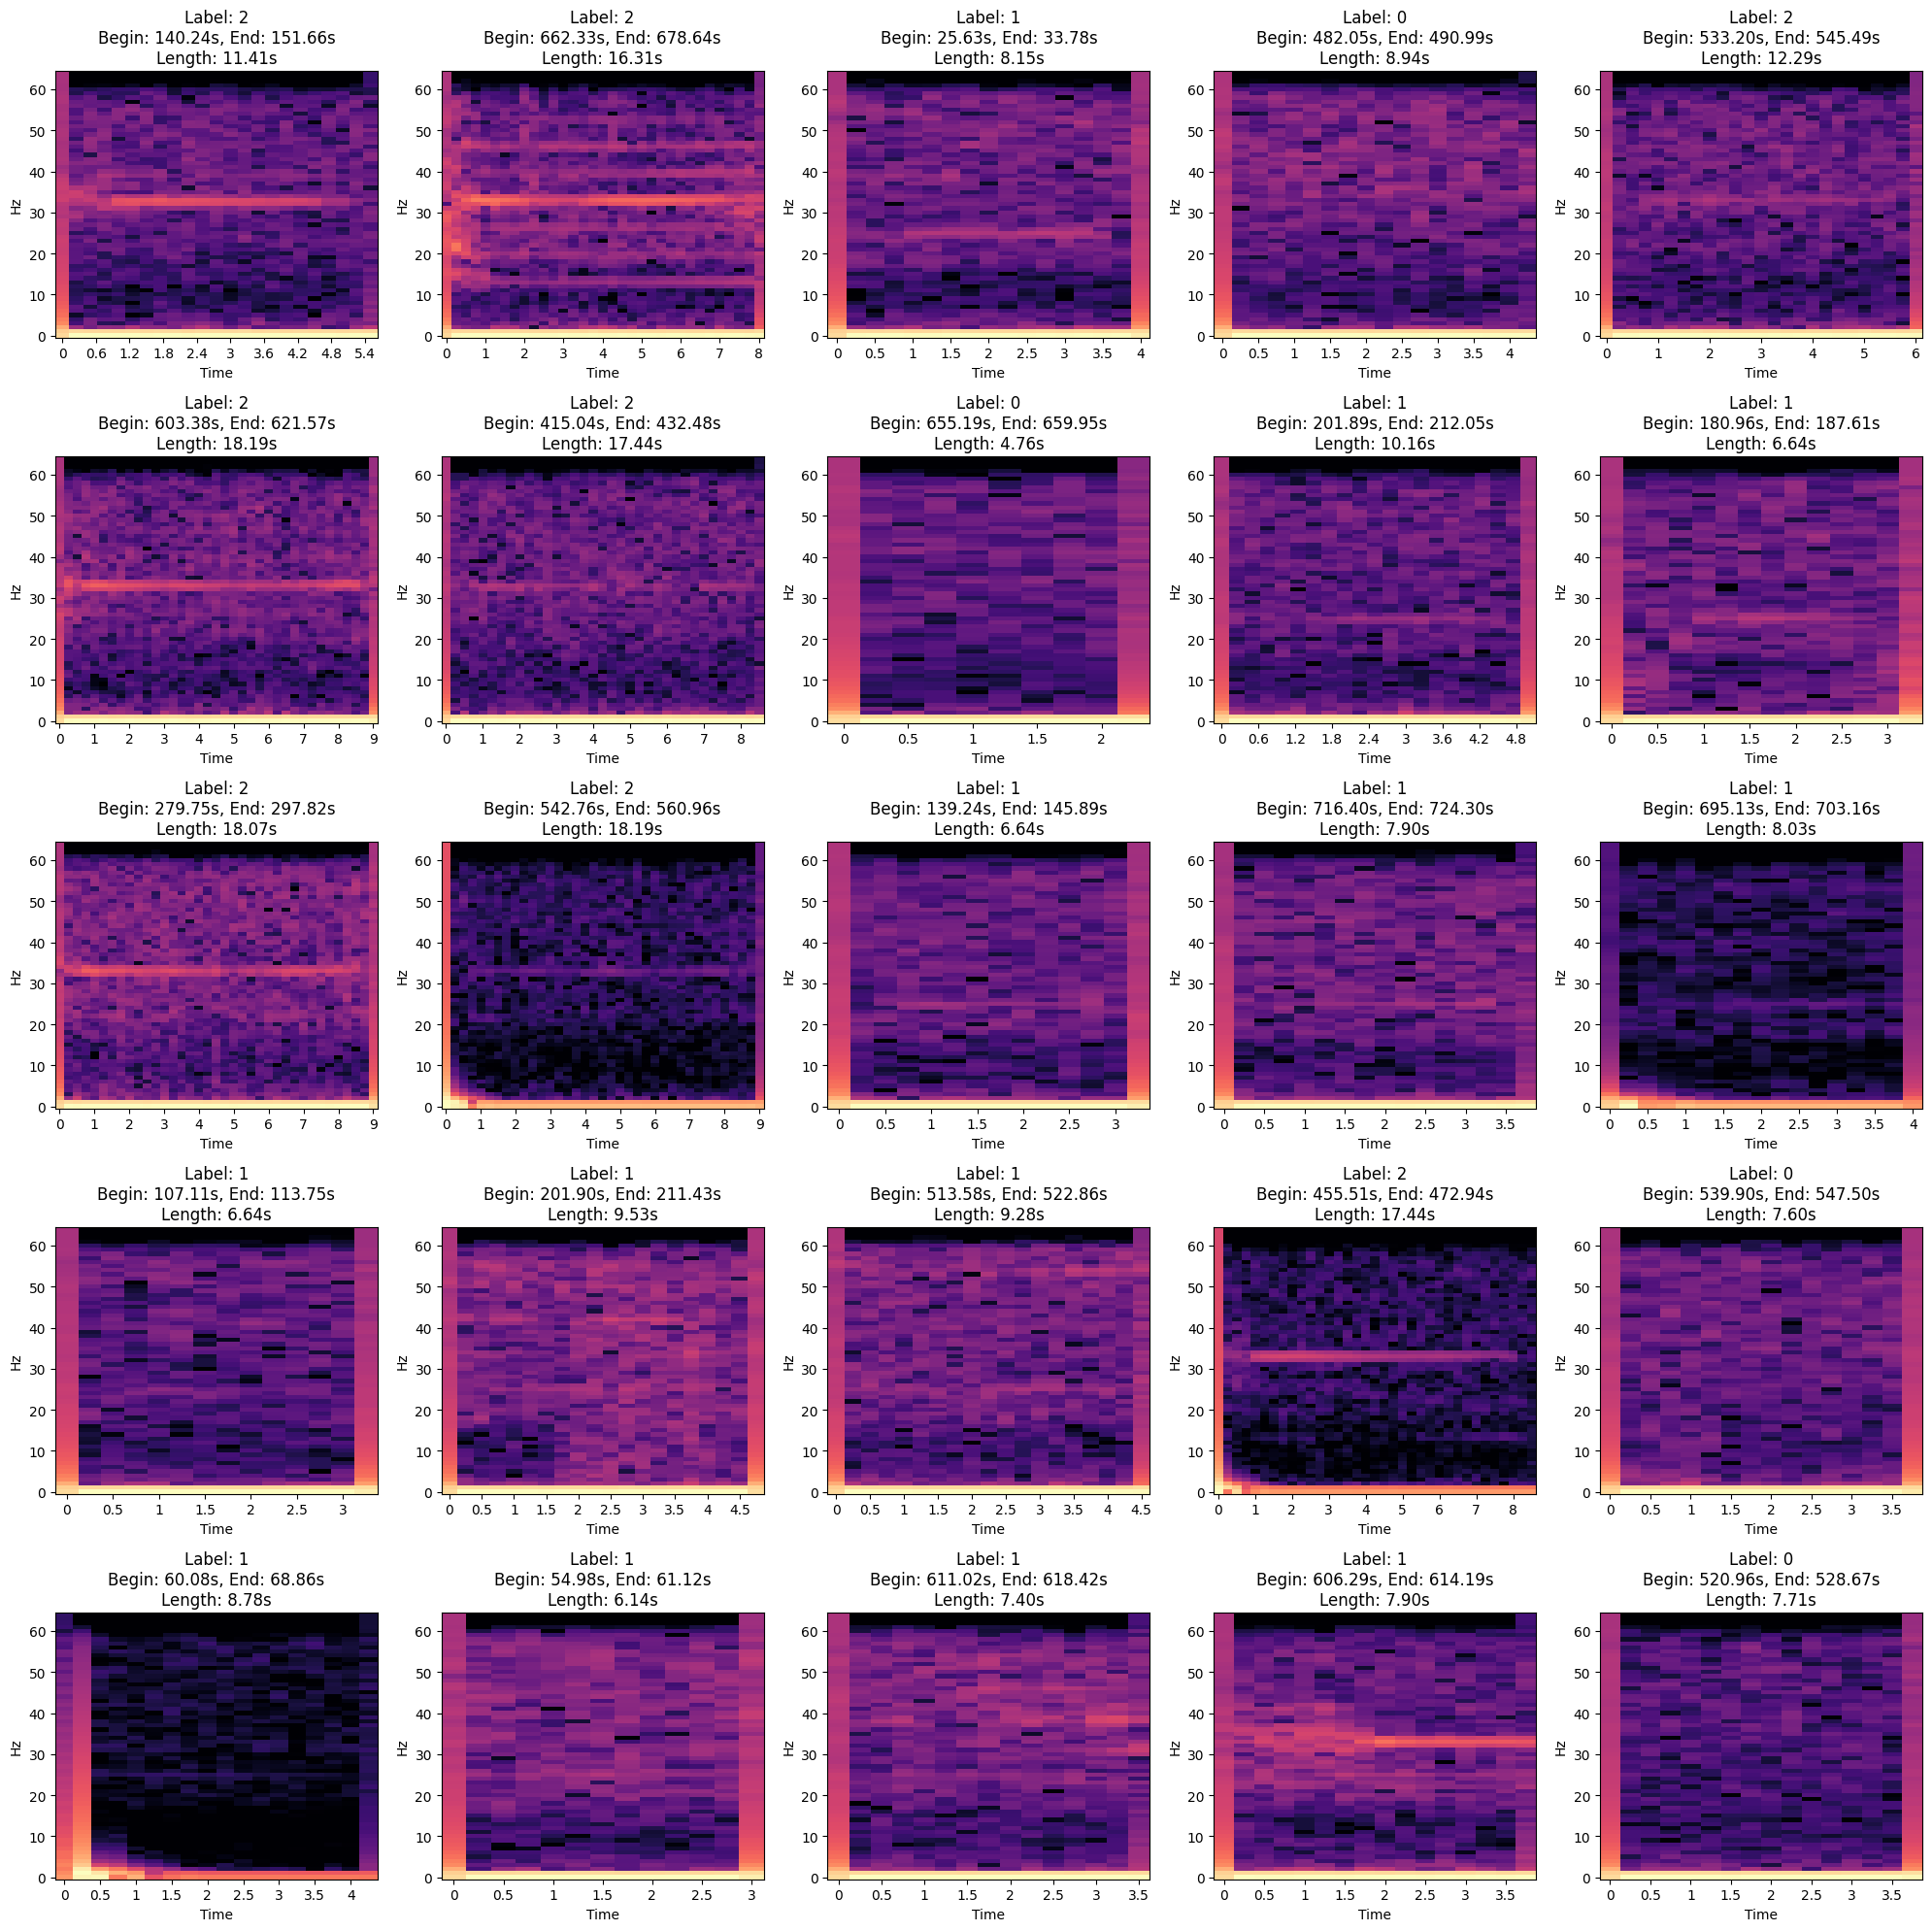

In [ ]:
# check the labels:
import matplotlib.pyplot as plt
import librosa
import librosa.display

fig, axes = plt.subplots(5, 5, figsize=(20, 20))
# choose randomly 25 samples from train_df
sampled_df = train_df.sample(n=25, random_state=42)
time_before = 1.0  # seconds before the call
time_after = 1.0   # seconds after the call
for i, ax in enumerate(axes.flat):
    wave, sr = sf.read(DATASET_PATH / (sampled_df['filename'].iloc[i] + '.wav'))
    wave = librosa.resample(wave, orig_sr=sr, target_sr=128)  # resample to 128 Hz
    sr = 128  # update sample rate to 128 Hz
    begin_time = sampled_df['begin_time'].iloc[i] - time_before
    end_time = sampled_df['end_time'].iloc[i] + time_after
    signal = wave[int(begin_time * sr):int(end_time * sr)]
    ## Mel spectrogram
    # S = librosa.feature.melspectrogram(y=signal, sr=sr, n_fft=128, hop_length=32, n_mels=64)
    # S_db = librosa.amplitude_to_db(S, ref=np.max)
    # print(f"Signal shape: {signal.shape}, S_db shape: {S_db.shape}")
    # librosa.display.specshow(S_db, sr=sr, hop_length=32, x_axis='time', y_axis='mel', ax=ax)
    
    # Spectrogram
    S = np.abs(librosa.stft(signal, n_fft=128, hop_length=32))
    # print("S shape:", S.shape)
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    # print("S_dB shape:", S.shape)
    librosa.display.specshow(S_db, sr=sr, hop_length=32, x_axis='time', y_axis='linear', ax=ax, cmap='magma')

    ax.set_title(f"Label: {sampled_df['label'].iloc[i]}\n"
                 f"Begin: {begin_time:.2f}s, End: {end_time:.2f}s\n"
                 f"Length: {end_time - begin_time:.2f}s")
    # ax.vlines([time_before], ymin=0, ymax=120, colors='r')
    # ax.axis('off')
plt.tight_layout()
plt.show()

(215048,) 256
(215048,)


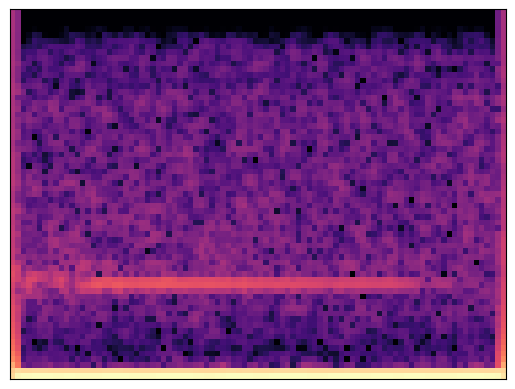

In [139]:
wave, sr = librosa.load(DATASET_PATH / (sampled_df['filename'].iloc[0] + '.wav'), sr=256)
print(wave.shape, sr)
# wave = wave[np.newaxis, :]  # add a new axis to make it 2D
D = librosa.stft(wave[int(begin_time * sr):int(end_time * sr)], n_fft=128, hop_length=32)  # STFT of wave
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
print(wave.shape)
librosa.display.specshow(S_db, sr=sr, n_fft=128, hop_length=32)
# plt.specgram(wave[int(begin_time * sr):int(end_time * sr)], Fs=sr, NFFT=128, noverlap=32, cmap='viridis')
plt.show()